## Здравствуйте, меня зовут *Михаил Солоткий*, вот моё Задание №1 по курсу ПСАД-2019!

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

In [2]:
from scipy.stats import linregress

def draw_linear(x, y, x_name='', y_name=''):
    "Scatter x-y points and draw a LR line."
    slope, intercept, r, _, _ = linregress(x, y)
    x_lims = np.array([x.min() - 1, x.max() + 1])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.plot(x, y, 'g+', label='Objects')
    plt.plot(x_lims, intercept + slope * x_lims, 'r--', label=r"LR line with $\rho \approx {:.3f}$".format(r))
    plt.legend()
    plt.show()

In [3]:
from sklearn.metrics import confusion_matrix

def draw_cm(x_bin, y_bin, x_name='', y_name=''):
    "Draw a confusion matrix for binary 1-D arrays x_bin and y_bin."
    cm = confusion_matrix(x_bin, y_bin)
    plt.matshow(cm)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [4]:
from itertools import combinations
from collections import defaultdict

def apply_pair_statistics(S, pair_statistics, statistics_names):
    """Apply pair statistics to each pair in a dataset S 
    and return a DataFrame containing the results.
    
    Parameters
    ----------
    S: array of shape (N, D)
        A dataset numpy array.
    pair_statistics: list of callables
        A list of statistics -- functions requiring two array arguments (x and y) 
        and returning a number (statistic's value)
    statistics_names: list of strings
        A list of statistics names.
    """
    res = defaultdict(list)

    for i, j in combinations(range(S.shape[1]), 2):
        x_name, y_name = f'X{i+1}', f'X{j+1}'
        x, y = S.T[i], S.T[j]
        res["Pair"].append(x_name + ' - ' + y_name)
        for statistic, name in zip(pair_statistics, statistics_names):
            res[name].append(statistic(x, y))

    res = pd.DataFrame(res)
    return res

## Итак...

Пусть задана обучающая выборка $\widetilde{S}$, включающая значения переменных $X_1, \dots, X_4$.

In [5]:
S = np.load('data')

### Задача 1  

Вычислите для каждой пары переменных коэффициент корреляции Пирсона.

In [6]:
S.shape

(57, 4)

In [7]:
def variance(x):
    return np.mean(x ** 2) - x.mean() ** 2

In [8]:
def pearson(x, y):
    "Calculate a Pearson correlation coefficient given 1-D data arrays x and y."
    return np.mean((x - x.mean()) * (y - y.mean())) / np.sqrt(variance(x) * variance(y))

In [9]:
res_pearson = apply_pair_statistics(S, [pearson], ['Pearson'])
res_pearson

,Pair,Pearson
0,X1 - X2,0.717535
1,X1 - X3,0.214944
2,X1 - X4,0.179368
3,X2 - X3,0.388575
4,X2 - X4,0.352562
5,X3 - X4,0.873796


Сопоставьте каждой из переменных  $X_1,\dots,X_4$  соответствующую порядковую переменную.

In [10]:
def rank(x):
    "Assign ranks to data and return the resulting ranking array."
    argsort_ = np.argsort(x)
    inverse_argsort = np.argsort(argsort_)
    sorted_x = x[argsort_]
    ranks = np.arange(1, len(x) + 1, dtype=np.float)
    begin_ind = -1
    for i in range(1, len(x)):
        if sorted_x[i] == sorted_x[i - 1]:
            if begin_ind == -1:
                begin_ind = i - 1
        else:
            if begin_ind != -1:
                ranks[begin_ind:i] = ranks[begin_ind:i].mean()
                begin_ind = -1
    if begin_ind != -1:
        ranks[begin_ind:] = ranks[begin_ind:].mean()
    return ranks[inverse_argsort]

In [11]:
rank(np.array([1.2, 0.8, 3.0, 0.8]))

array([3. , 1.5, 4. , 1.5])

In [12]:
S_r = np.array([rank(x) for x in S.T]).T

Вычислите для каждой из пар переменных коэффициенты корреляции Спирмена и Кендалла ($\tau$-коэффициент).

In [13]:
def spearman(x_r, y_r):
    "Calculate a Spearman correlation coefficient given 1-D ranking arrays x_r and y_r."
    return pearson(x_r, y_r)

def kendall(x_r, y_r):
    "Calculate a Kendall tau correlation coefficient given 1-D ranking arrays x_r and y_r."
    n_c =  ((x_r[:, np.newaxis] > x_r[np.newaxis, :]) * (y_r[:, np.newaxis] > y_r[np.newaxis, :])).sum()
    n_c += ((x_r[:, np.newaxis] < x_r[np.newaxis, :]) * (y_r[:, np.newaxis] < y_r[np.newaxis, :])).sum()
    n_nc =  ((x_r[:, np.newaxis] > x_r[np.newaxis, :]) * (y_r[:, np.newaxis] < y_r[np.newaxis, :])).sum()
    n_nc += ((x_r[:, np.newaxis] < x_r[np.newaxis, :]) * (y_r[:, np.newaxis] > y_r[np.newaxis, :])).sum()
    return (n_c - n_nc) / (len(x_r) * (len(x_r) - 1))

In [14]:
res_ranked = apply_pair_statistics(S_r, [spearman, kendall], ['Spearman', 'Kendall'])
res_ranked

,Pair,Spearman,Kendall
0,X1 - X2,0.999789,0.993734
1,X1 - X3,0.068620,0.050752
2,X1 - X4,0.047029,0.038221
3,X2 - X3,0.070098,0.052632
4,X2 - X4,0.048231,0.041353
5,X3 - X4,0.819520,0.648496


Посмотрите на общую таблицу результатов и на графики ниже, сделайте выводы. 

При желании можно построить свои графики / вывести дополнительные результаты.

In [15]:
res_final = pd.merge(res_pearson, res_ranked)
res_final

,Pair,Pearson,Spearman,Kendall
0,X1 - X2,0.717535,0.999789,0.993734
1,X1 - X3,0.214944,0.068620,0.050752
2,X1 - X4,0.179368,0.047029,0.038221
3,X2 - X3,0.388575,0.070098,0.052632
4,X2 - X4,0.352562,0.048231,0.041353
5,X3 - X4,0.873796,0.819520,0.648496


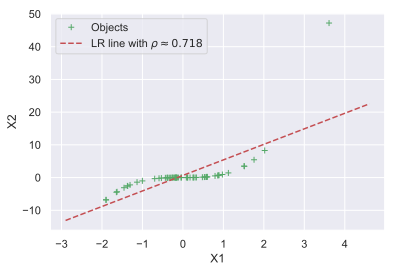

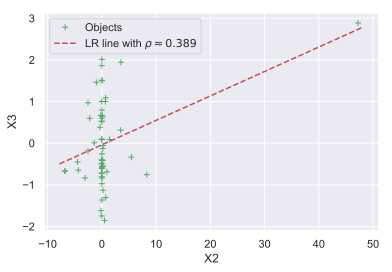

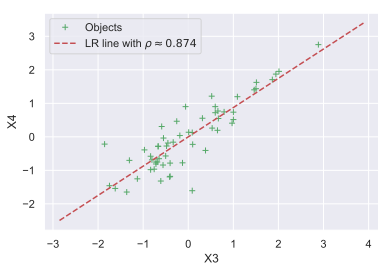

In [16]:
draw_linear(S.T[0], S.T[1], 'X1', 'X2')
draw_linear(S.T[1], S.T[2], 'X2', 'X3')
draw_linear(S.T[2], S.T[3], 'X3', 'X4')

**Выводы:** так как коэффициенты корреляции Спирмена и Кендалла инвариантен относительно монотонного преобразования, на паре величин (X1, X2) этот коэффициент высокий. Зависимость явно нелинейная, но похожа на неё, поэтому коэффициент Пирсона меньше Спирмена и Кендалла, но всё-равно высокий. Для пары величин (X2, X3) все коэффициенты низкие, так как тут непонятная какая-то зависимость. А в случай пары величин (X3, X4) образцово-показательный для применения линейной регрессии (где-то я такие картинки уже видел). Вместе с тех коэффициент Пирсона в данном случае наибольший среди пар (Xi, Xj), значения коэффициентов Кендалла и Спирмена также высокие.

### Задача 2


Бинаризуйте выборку $\widetilde{S}$ по медиане.

In [17]:
S_bin = np.empty(S.shape, dtype=np.int)
for i in range(S.shape[1]):
    sorted_x = np.sort(S[:, i])
    S_bin[:, i] = (S[:, i] > sorted_x[len(sorted_x) // 2])

Вычислите для каждой пары бинаризованных переменных коэффициенты близости Жаккара и $\phi$.

In [18]:
def jaccard(x_bin, y_bin):
    "Compute the Jaccard coefficient given 1-D boolean arrays x_bin and y_bin."
    return (x_bin & y_bin).sum() / (x_bin | y_bin).sum()

def phi(x_bin, y_bin):
    "Compute the phi coefficient given 1-D boolean arrays x_bin and y_bin."
    # https://en.wikipedia.org/wiki/Phi_coefficient
    n11 = (x_bin & y_bin).sum()
    n10 = (x_bin & (1 - y_bin)).sum()
    n01 = ((1 - x_bin) & y_bin).sum()
    n00 = ((1 - x_bin) & (1 - y_bin)).sum()
    n1_ = n11 + n10
    n0_ = n01 + n00
    n_1 = n11 + n01
    n_0 = n00 + n10
    return (n11 * n00 - n10 * n01) / np.sqrt(n1_ * n0_ * n_1 * n_0)

In [19]:
res_bin = apply_pair_statistics(S_bin, [jaccard, phi], ['Jaccard', 'Phi'])
res_bin

,Pair,Jaccard,Phi
0,X1 - X2,1.000000,1.000000
1,X1 - X3,0.302326,-0.052956
2,X1 - X4,0.365854,0.087438
3,X2 - X3,0.302326,-0.052956
4,X2 - X4,0.365854,0.087438
5,X3 - X4,0.750000,0.719212


Сделайте выводы по полученным результатам и приведённым ниже матрицам ошибок.

При желании можно построить свои графики / вывести дополнительные результаты.

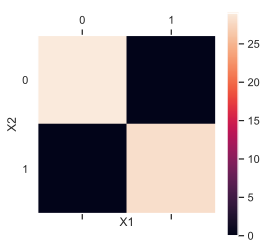

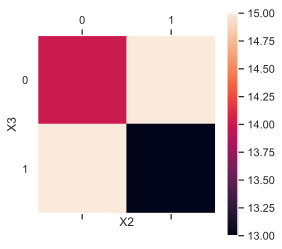

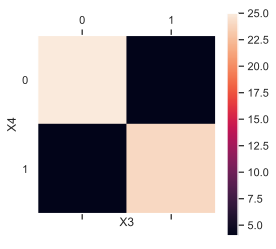

In [20]:
draw_cm(S_bin.T[0], S_bin.T[1], 'X1', 'X2')
draw_cm(S_bin.T[1], S_bin.T[2], 'X2', 'X3')
draw_cm(S_bin.T[2], S_bin.T[3], 'X3', 'X4')

**Выводы:** так как величины (X1, X2) связаны некоторой монотонной зависимостью (или близкой к ней), коэффициент Жаккара на бинаризованных по медиане величинах принимает максимальное значение: 1, вместе с тем коэффициент $\phi$ принимает значение, противоположное по знаку: -1. Для пары величин (X2, X3) зависимость какая-то странная, и в данном случае наложение бинаризованных величин по значению 0 было малым (около 13%, судя по confussion matrix). Картинка для пар величин (X3, X4) похожа на соответствующую для величин (X1, X2), разве что телесный цвет на диаграмме немного другого оттенка, что сходится с высоким коэффициентом $\phi$, высоким коэффициентом Жаккара и тем фактом, что между величинами (X3, X4) прослеживается явная линейная связь.